In [1]:
# IMPORTING LIBRARIES

import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import pytorch_lightning as pl

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE = 128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count() / 2)

In [2]:
# CREATING DATA MODULE

class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )
    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # ASSIGNING TRAIN/VAL DATASETS
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # ASSIGNING TESTING DATASET
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return Dataloader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return Dataloader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

In [3]:
# DISCRIMINATOR: Detect if Data is Fake or Not -> 1 output [0, 1]

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # SIMPLE CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # FLATTEN TENSOR SO IT CAN BE FED INTO FC LAYERS
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [4]:
# GENERATOR: Generates Fake Data

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64) # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7) # [n, 1, 28, 28]

    def forward(self, x):
        # PASS LATENT SPACE INPUT IN LINEAR LAYER AND RESHAPE
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7) # 256

        # UPSAMPLE (TRANSPOSED CONV) 16X16 (64 FEATURE MAPS)
        x = self.ct1(x)
        x = F.relu(x)

        # UPSAMPLE TO 34X34 (16 FEATURE MAPS)
        x = self.ct2(x)
        x = F.relu(x)

        # CONVOLUTION TO 28X28 (1 FEATURE MAP)
        return self.conv(x)

In [9]:
# CREATING GENERATIVE ADVERSARIAL NETWORK CLASS

class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()

        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        # RANDOM NOISE
        self.validation_z = torch.randn(6, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx, optimizer_idx):
        real_imgs, _ = batch

        # SAMPLE NOISE
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)

        # TRAIN GENERATOR: max log(Discriminator(Generator(z:random_noise)))
        if optimizer_idx == 0:
            fake_imgs = self(z)
            y_hat = self.discriminator(fake_imgs)

            y = torch.ones(real_imgs.size(0), 1)
            y = y.type_as(real_imgs)

            g_loss = self.adversarial_loss(y_hat, y)

            log_dict = {"g_loss": g_loss}
            return {"loss": g_loss, "progress_bar": log_dict, "log": log_dict}

        # TRAIN DISCRIMINATOR: max log (D(x)) + log(1 - D(G(z)))
        if optimizer_idx == 1:

            # HOW WELL CAN IT DETECT REAL
            y_hat_real = self.discriminator(real_imgs)
            y_real = torch.ones(real_imgs.size(0), 1)
            y_real = y_real.type_as(real_imgs)

            real_loss = self.adversarial_loss(y_hat_real, y_real)
            
            # HOW WELL CAN IT DETECT FAKE
            y_hat_fake = self.discriminator(self(z).detach())

            y_fake = torch.zeros(real_imgs.size(0), 1)
            y_fake = y_fake.type_as(real_imgs)

            fake_loss = self.adversarial_loss(y_hat_fake, y_fake)
            d_loss = (real_loss + fake_loss) / 2

            log_dict = {"d_loss": d_loss}
            return {"loss": d_loss, "progress_bar": log_dict, "log": log_dict}

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []

    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()

        print('epoch', self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap='gray_r', interpolation='none')
            plt.title("Generated Data")
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()

    def on_epoch_end(self):
        self.plot_imgs()
    

In [10]:
# THE SETUP

dm = MNISTDataModule()
model = GAN()

epoch 0


/var/folders/h7/xbt09_t16w7blpfl9452_x4c0000gp/T/ipykernel_11912/1689669189.py:76: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


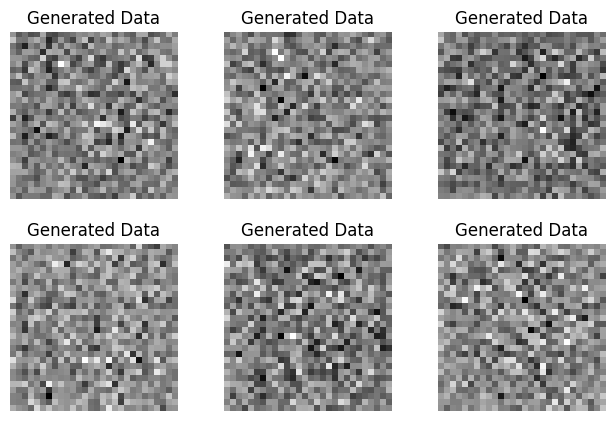

In [11]:
model.plot_imgs()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Epoch 0: 100%|█████████████████| 430/430 [01:43<00:00,  4.17it/s, loss=1.47, v_num=1]epoch 0


/var/folders/h7/xbt09_t16w7blpfl9452_x4c0000gp/T/ipykernel_11912/1689669189.py:76: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


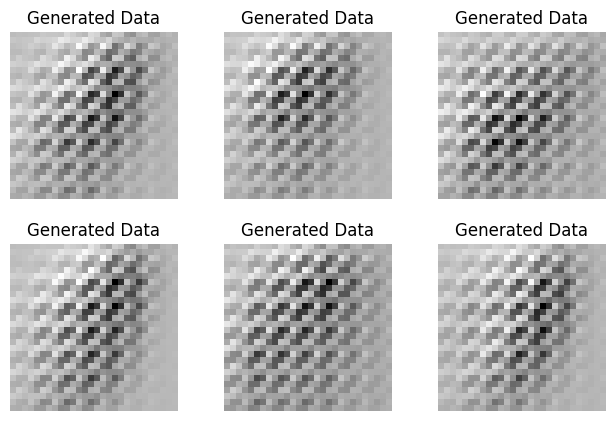

Epoch 1: 100%|█████████████████| 430/430 [01:38<00:00,  4.37it/s, loss=1.16, v_num=1]epoch 1


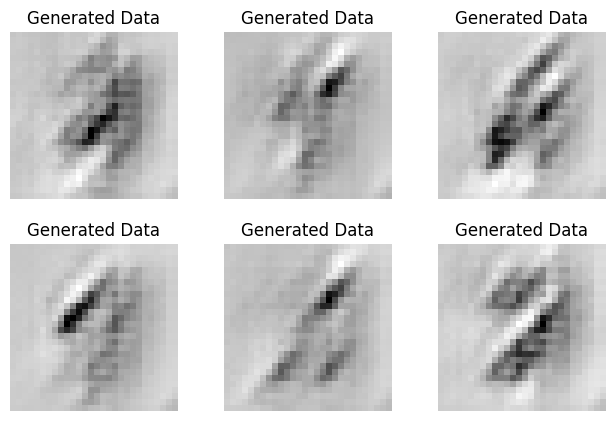

Epoch 2: 100%|█████████████████| 430/430 [01:38<00:00,  4.36it/s, loss=1.22, v_num=1]epoch 2


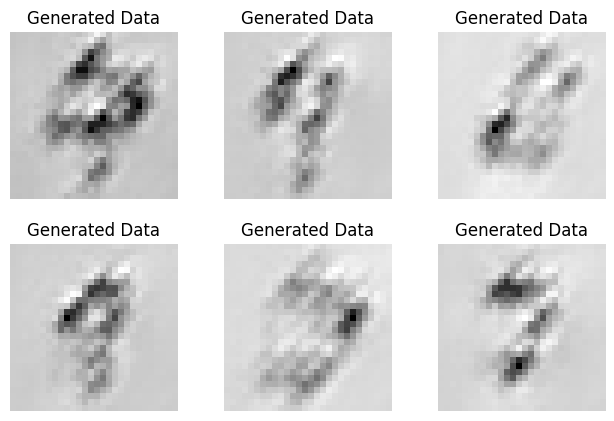

Epoch 3: 100%|█████████████████| 430/430 [01:38<00:00,  4.38it/s, loss=1.29, v_num=1]epoch 3


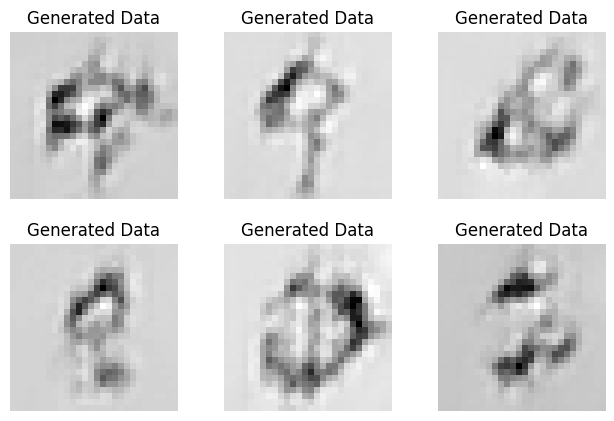

Epoch 4: 100%|█████████████████| 430/430 [01:39<00:00,  4.33it/s, loss=1.44, v_num=1]epoch 4


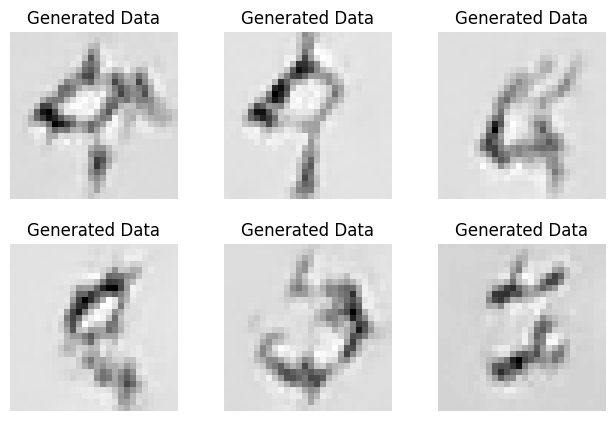

Epoch 5: 100%|█████████████████| 430/430 [01:39<00:00,  4.30it/s, loss=1.44, v_num=1]epoch 5


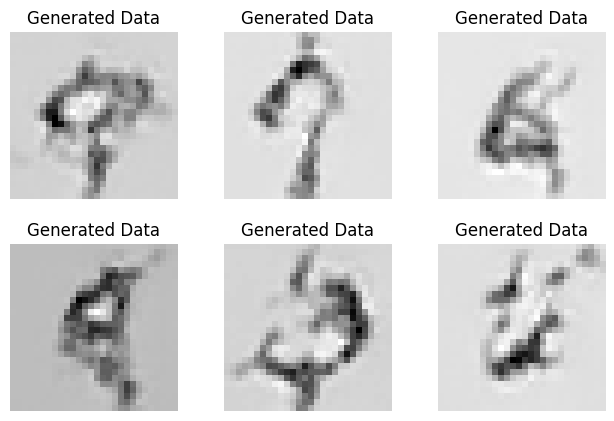

Epoch 6: 100%|█████████████████| 430/430 [01:38<00:00,  4.36it/s, loss=1.34, v_num=1]epoch 6


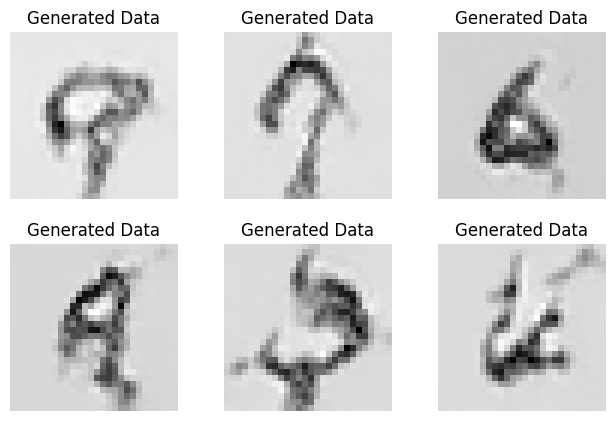

Epoch 7: 100%|█████████████████| 430/430 [01:37<00:00,  4.43it/s, loss=1.39, v_num=1]epoch 7


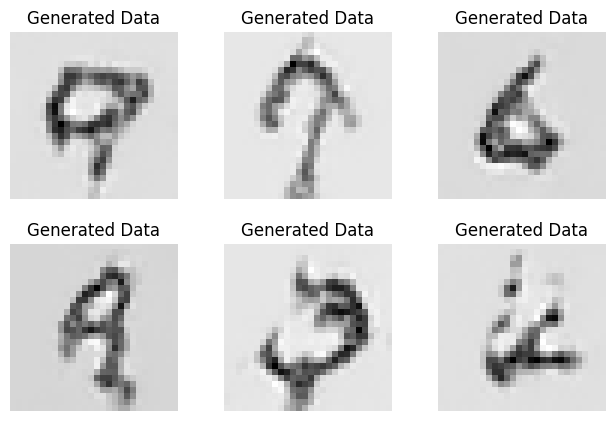

Epoch 8: 100%|█████████████████| 430/430 [01:37<00:00,  4.40it/s, loss=1.25, v_num=1]epoch 8


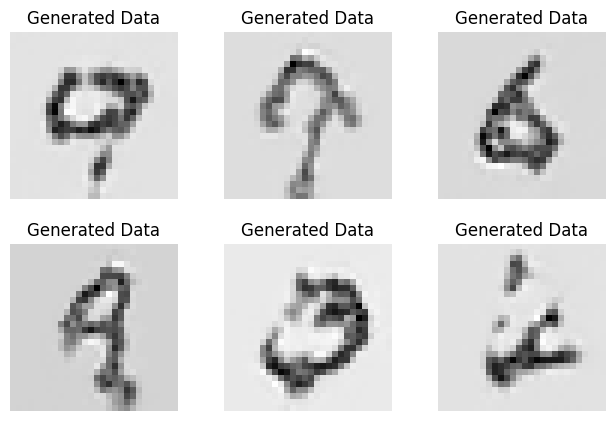

Epoch 9: 100%|█████████████████| 430/430 [01:37<00:00,  4.41it/s, loss=1.24, v_num=1]epoch 9


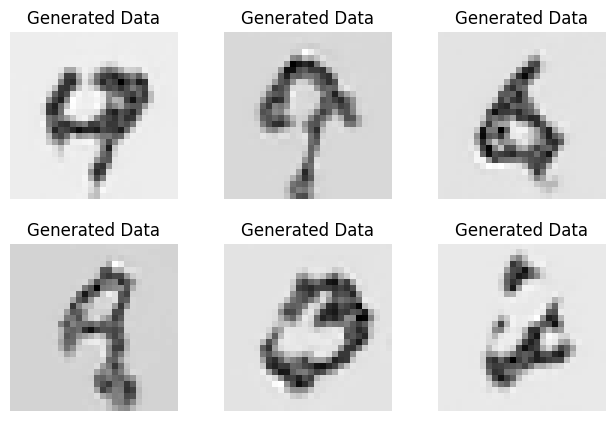

Epoch 10: 100%|████████████████| 430/430 [01:37<00:00,  4.43it/s, loss=1.18, v_num=1]epoch 10


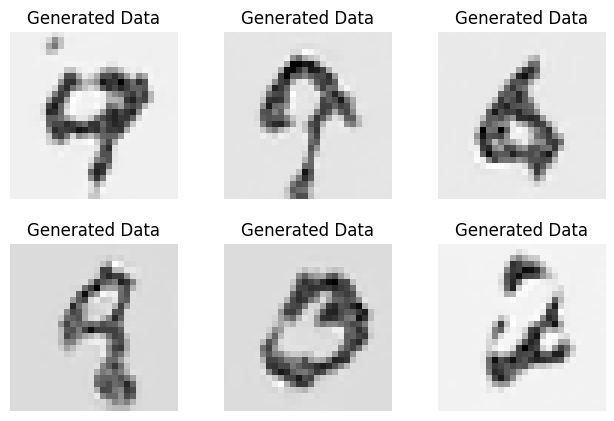

Epoch 11: 100%|████████████████| 430/430 [01:38<00:00,  4.35it/s, loss=1.17, v_num=1]epoch 11


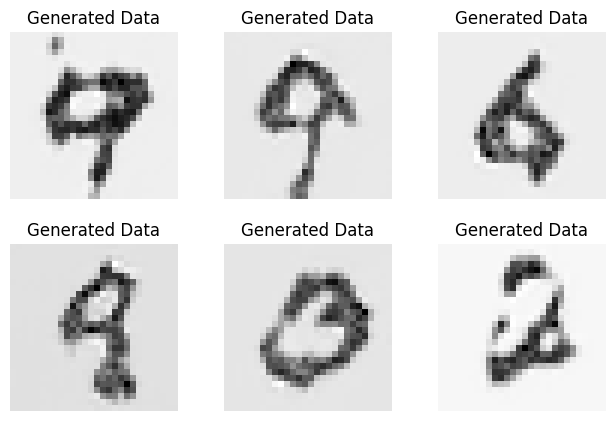

Epoch 12: 100%|████████████████| 430/430 [01:39<00:00,  4.34it/s, loss=1.04, v_num=1]epoch 12


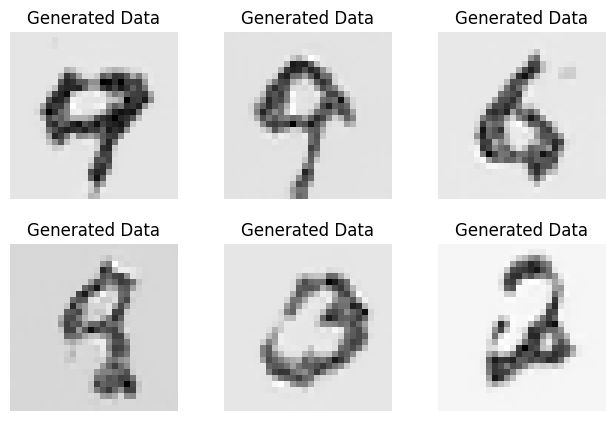

Epoch 13: 100%|████████████████| 430/430 [01:38<00:00,  4.37it/s, loss=1.09, v_num=1]epoch 13


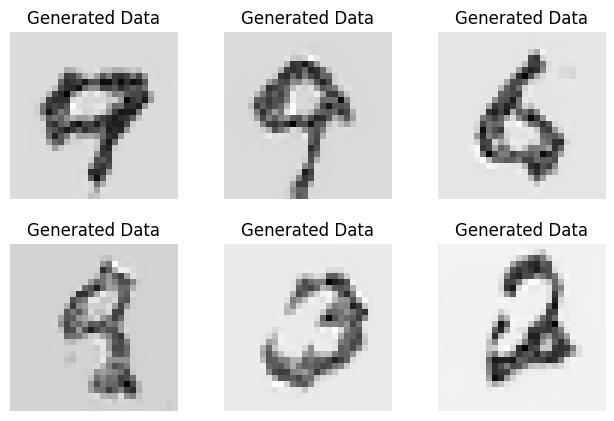

Epoch 14: 100%|████████████████| 430/430 [01:39<00:00,  4.33it/s, loss=1.07, v_num=1]epoch 14


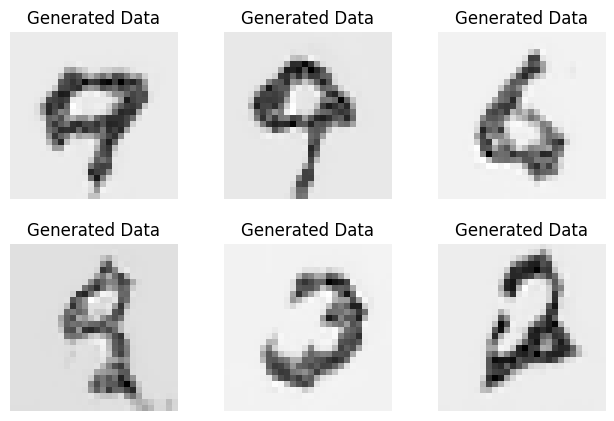

Epoch 15: 100%|████████████████| 430/430 [01:38<00:00,  4.35it/s, loss=1.07, v_num=1]epoch 15


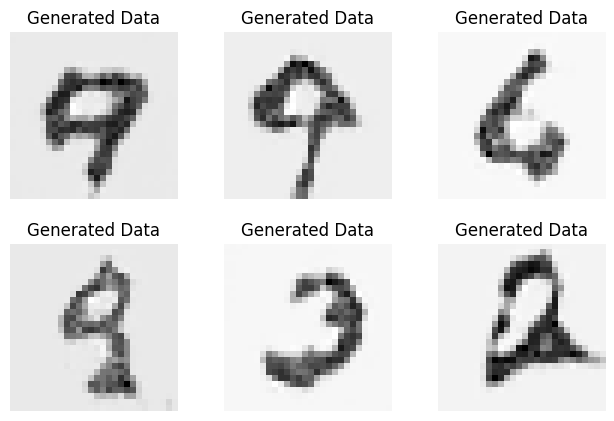

Epoch 16: 100%|███████████████████| 430/430 [01:36<00:00,  4.47it/s, loss=1, v_num=1]epoch 16


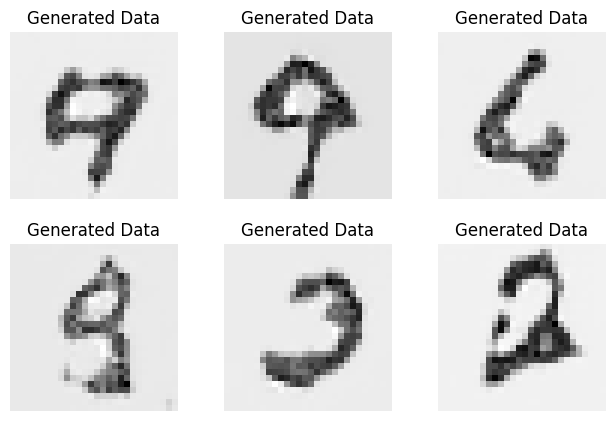

Epoch 17: 100%|████████████████| 430/430 [01:39<00:00,  4.34it/s, loss=1.05, v_num=1]epoch 17


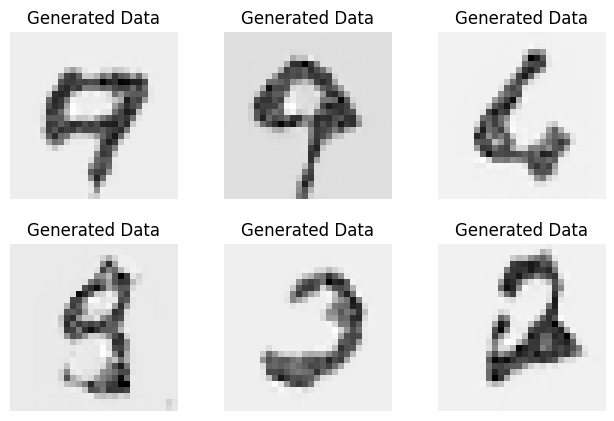

Epoch 18: 100%|████████████████| 430/430 [01:42<00:00,  4.20it/s, loss=1.04, v_num=1]epoch 18


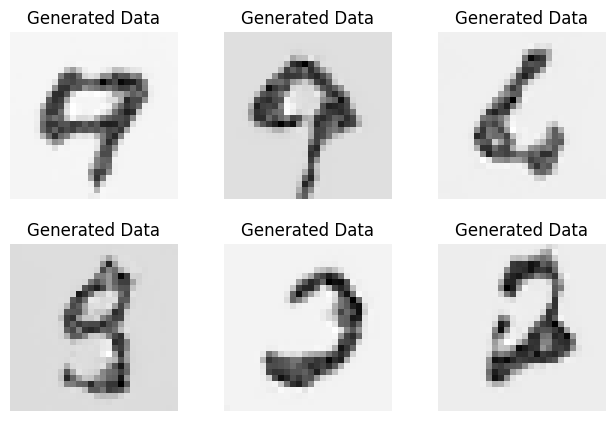

Epoch 19: 100%|███████████████| 430/430 [01:39<00:00,  4.32it/s, loss=0.973, v_num=1]epoch 19


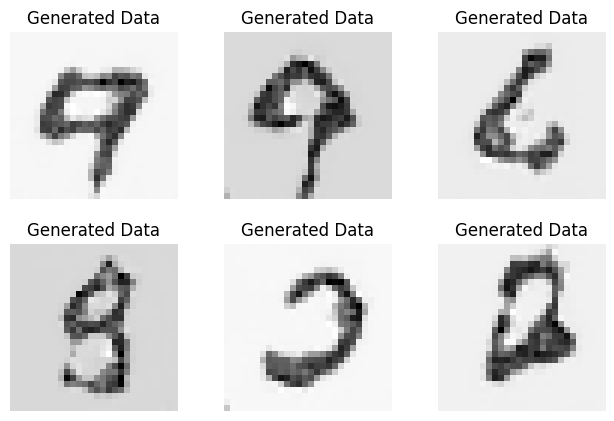

Epoch 19: 100%|███████████████| 430/430 [01:39<00:00,  4.31it/s, loss=0.973, v_num=1]


In [12]:
trainer = pl.Trainer(max_epochs=20, gpus=AVAIL_GPUS)
trainer.fit(model, dm)